In [1]:
%matplotlib inline

goal:

an analysis with specific papers.
look at interdisciplinary papers, within discipline papers, and any
new post-hoc statistics that you think could be interesting.  for how
to do this, see our papers on collaborative topic modeling and my talk
about it (all on my website).  ask me if you are confused how to do
this.  i'm also interested in how this model fails on this data.  (we
know it must.)

a super thorough look at
this model would also consider the held out predictions and specific
users.  you would understand their interests via their clicks, and how
the model has captured or not captured them.

In [140]:
# replicate the functionality of explore-coll-msd-tm.R for posterity and general ease of use
import numpy as np
import cPickle as pickle
import pandas as pd
import rec_eval
import matplotlib
import h5py
matplotlib.style.use('ggplot')
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
#fitPath = "/scratch/shared/music_project/jaan/ctpf-fits/collabtm/src/nusers1128835-ndocs202994-nvocab256-k50-batch-bin-vb-fa-ldainit/"

# fit path
fitPath = '/home/waldorf/altosaar/projects/arxiv/fit/2015-11-10_best_ll-ctpf-categorywise_true-converge_in_category_first/'

# output file
fName = fitPath + 'arxiv-categories-ctpf-2.txt'

# maps
in_dir = '/home/statler/lcharlin/arxiv/dat/dataset_2003-2012_clean/'
id2arxiv_info = pd.read_csv(in_dir + 'items_arxiv_info.tsv', header=None, delimiter='\t', names=['arxiv_id', 'categories', 'title', 'date'])

check that we have the right categories in the map:

In [3]:
document_category_dummies = id2arxiv_info['categories'].str.join(sep='').str.get_dummies(sep=' ')
category_list = list(document_category_dummies.columns)

In [4]:
observed_categories = document_category_dummies.as_matrix().astype(np.float32)

In [6]:
topic2category = {k:category for k, category in enumerate(category_list)}
category2topic = {v:k for k, v in topic2category.items()}

# NB: here theta = topic matrix, but in my fits, theta = user prefs matrix!

In [136]:
# # load theta
# for fixed (observed) theta the code adds a small prior value (0.0308...) to each entry
# tName = fitPath + 'theta.tsv'
# # skip first two cols, and first row
# theta = pd.read_csv(tName, delimiter='\t', header=None).iloc[0:,2:]

# this is the fixed theta (according to arxiv category)
fitFile = fitPath + 'fit.h5'
h5f = h5py.File(fitFile, 'r')
theta_t = h5f['Ebs_t'][:]
epsilon_t = h5f['Eba_t'][:]
beta_t = h5f['Et_t'][:]
#theta = observed_categories #pickle.load(open(tName, 'rb'))#pd.read_csv(tName, delimiter=' ', header=None)

In [137]:
beta = beta_t.T

In [11]:
observed_categories == theta_t.T

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ..., 
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]], dtype=bool)

In [12]:
theta = observed_categories

In [13]:
#theta = theta.as_matrix()
# normalize
# def normalizeRow(row):
#     return row / np.sum(row)
#theta.apply(normalizeRow, axis=0)

# num topics
k = len(theta[0])

# load epsilon
#eName = '/home/waldorf/altosaar/projects/arxiv/fit/ctpf-stagewise/Eba-ie-epsilon.pkl'

# skip first 2 cols
#epsilon = pickle.load(open(eName, 'rb'))#pd.read_csv(eName, delimiter='\t', header=None).iloc[0:,2:]
epsilon = epsilon_t.T

In [15]:
#epsilon = epsilon.as_matrix()

# load id2word
#mapName = '/scratch/shared/music_project/jaan/lda-fits/dat/id2word.pickle'
#id2word = pickle.load(open(mapName, 'rb'))

th_ep = theta + epsilon
th_ep_rs = np.sum(th_ep,axis=1)

In [16]:
id2arxiv_info.index = range(0, len(id2arxiv_info))

In [17]:
id2item_dict = id2arxiv_info.to_dict()

id2title = id2item_dict['title']
#id2title[0] = 'dummy title'
normth = theta

now we're ready to check if the observed topics match what's in our article id to title/arxiv id map. it checks out:

In [18]:
print np.where(theta[3434] == 1)
print topic2category[np.where(theta[3434] == 1)[0][0]]

print id2title[3434]

(array([19, 26]),)
cond-mat.mes-hall
Effects of a Fluctuating Interface between a Superfluid and a Polarized Fermi Gas


In [19]:
topic2category[26], topic2category[19]

('cond-mat.supr-con', 'cond-mat.mes-hall')

In [20]:
print th_ep.shape, th_ep_rs.shape

(806139, 166) (806139,)


In [21]:
# number of articles in category 0.
np.where(normth[:,0] > 0)[0].shape

(47,)

In [22]:
#working
def similarArticles(docId, theta, n):
    sqrt_normed_theta = np.sqrt(normth[docId])
    a = np.sum(np.power(np.sqrt(normththeta) - sqrt_normed_theta,2),axis=1)
    # this was in reverse
    top = np.argsort(a)
    for topId in top[0:n]:
        print "%0.3f  %s" %(a[topId],id2title[topId])

#working
def topArticles(k,normth=normth,n=10):
    top = np.argsort(normth[:,k])[::-1]
    return ["%0.3f  %s" %(normth[topId,k],id2title[topId]) for topId in top[0:n]]
    #for topId in top[0:n]:
        #print "%0.3f  %s" %(normth[topId,k],id2title[topId]))
        
#working! mistake was that i added normalized theta to eps for th_ep.
def inFieldArticles(k,th_ep=th_ep,normth=normth,n=10,prop=0.15):
    ind = np.where(normth[:,k] > prop)
    th_ep_ind = th_ep[ind,k][0]
    top = np.argsort(th_ep_ind)[::-1]
    return ["%0.3f  %s" %(th_ep_ind[topId],id2title[ind[0][topId]]) for topId in top[0:n]]
    #for topId in top[0:n]:
     #   print "%0.3f  %s" %(th_ep_ind[topId],id2title[ind[0][topId]]) 
        
#working
def outFieldArticles(k, th_ep=th_ep, normth=normth, n=10, prop=0.05):
    ind = np.where(normth[:,k] < prop)
    th_ep_ind = th_ep[ind,k][0]
    top = np.argsort(th_ep_ind)[::-1]
    return ["%0.3f  %s" %(th_ep_ind[topId],id2title[ind[0][topId]]) for topId in top[0:n]]
    #for topId in top[0:n]:
     #   print "%0.3f  %s" %(th_ep_ind[topId],id2title[ind[0][topId]])

#working
def interFieldArticles(k, rs = th_ep_rs, th_ep = th_ep, n = 10, prop = 0.15):
    ind = np.where(normth[:,k] > prop)
    rs_ind = rs[ind]
    th_ep_ind = th_ep[ind,k][0]
    score = rs_ind - th_ep_ind
    top = np.argsort(score)[::-1]
    return ["%0.3f  %s" %(score[topId],id2title[ind[0][topId]]) for topId in top[0:n]]
    #for topId in top[0:n]:
    #    print "%0.3f  %s" %(score[topId],id2title[ind[0][topId]])

In [23]:
with open(fName, 'wb') as f:
    print>>f, 'this fit is in: ' + fitPath + '\n'
    #print>>f, 'the dataset is in: ' + datasetPath + '\n'
    for k in range(0,len(theta[0] + 1)):
        print>>f, '\n--------------------------------\n'
        print>>f, 'category k = ' + str(topic2category[k]) + '\n'
        print>>f, 'random articles from category'
        topArt = topArticles(k)
        for line in topArt:
            print>>f, line
        print>>f,'\nin-field articles'
        inField = inFieldArticles(k)
        for line in inField:
            print>>f,line
        print>>f,'\nout-field articles'
        outField = outFieldArticles(k)
        for line in outField:
            print>>f,line
        print>>f,'\ninter-field articles'
        interField = interFieldArticles(k)
        for line in interField:
            print>>f,line

# look at articles in one field of interest to people in another

look at hep articles that are of most interest to cond-mat

In [186]:
def betweenFieldArticles(cat1, cat2, normth = normth, ep = epsilon, n = 10, prop = 0.15, verbose=True):
    avg_score1 = betweenFieldArticles_single(cat1, cat2, normth = normth, ep = epsilon, n = n, prop = prop, verbose=verbose)
    if verbose:
        print '====='
    avg_score2 = betweenFieldArticles_single(cat2, cat1, normth = normth, ep = epsilon, n = n, prop = prop, verbose=verbose)
    return np.abs(avg_score1 - avg_score2)

def betweenFieldArticles_single(cat1, cat2, normth = normth, ep = epsilon, n = 10, prop = 0.15, verbose=True):
    k1 = category2topic[cat1]
    k2 = category2topic[cat2]
    # article indices in topic k1
    ind = np.where(normth[:,k1] > prop)
    
    # popularity of articles in k1 in topic k2
    ep_ind = ep[ind,k2][0]
    
    # most popular articles with respect to k2 that are in k1
    top = np.argsort(ep_ind)[::-1]
    betweenField = ["%0.3f  %s" %(ep_ind[topId],id2title[ind[0][topId]]) for topId in top[0:n]]
    if verbose:
        print 'articles in {} of interest to folks in {}'.format(cat1, cat2)
        for line in betweenField:
            print line
    return ep_ind[top[0:n]].mean()

def cross_field_interest(field1):
    for field2 in category2topic.keys():
        print '==> {}, {}\n--'.format(field1, field2)
        betweenFieldArticles('stat.ML', field2, n=10)
        print '=============='
        
betweenFieldArticles('hep-ph', 'cond-mat', n=20)


articles in hep-ph of interest to folks in cond-mat
3998.993  Superfluid 3He, Particle Physics and Cosmology
3992.272  Casimir's energy of a conducting sphere and of a dilute dielectric ball
3916.000  Macroscopic parity violating effects and 3He-A
3860.006  Vierbein walls in condensed matter
3831.725  Nonperturbative XY-model approach to strong coupling superconductivity in two and three dimensions
3805.340  Cosmology in a Test Tube: Theory of Domain Walls Formation in Binary Fluids
3776.116  Effective Action and Conformal Phase Transition in Three-Dimensional QED
3652.721  Composite defect extends cosmology - 3He analogy
3562.397  Eliminating Infrared Divergences in the Pressure
3526.851  Theta-terms in nonlinear sigma-models
3439.527  Fermion Bags in the Massive Gross-Neveu Model
3419.335  On the Free-Energy of Three-Dimensional CFTs and Polylogarithms
3358.449  Fermion zero modes on vortices in chiral superconductors
3246.370  Gell-Mann - Low Function for QCD in the strong-coupling 

3278.3735

In [206]:
betweenFieldArticles('stat.ML', 'hep-ex', n=20)

articles in stat.ML of interest to folks in hep-ex
9.152  PDE-Foam - a probability-density estimation method using self-adapting phase-space binning
4.204  BAMBI: blind accelerated multimodal Bayesian inference
3.083  Semi-Supervised Anomaly Detection - Towards Model-Independent Searches of New Physics
1.456  Effect of Wind Intermittency on the Electric Grid: Mitigating the Risk of Energy Deficits
1.428  Isoelastic Agents and Wealth Updates in Machine Learning Markets
1.136  Entropy-Based Search Algorithm for Experimental Design
1.070  Improved RIP Analysis of Orthogonal Matching Pursuit
0.749  Dimensionally Constrained Symbolic Regression
0.727  Fast ABC-Boost for Multi-Class Classification
0.711  A History of Cluster Analysis Using the Classification Society's Bibliography Over Four Decades
0.704  Near-Optimal Target Learning With Stochastic Binary Signals
0.704  A Privacy-Aware Bayesian Approach for Combining Classifier and Cluster Ensembles
0.684  Fast Planar Correlation Clustering

0.98960137

In [170]:
betweenFieldArticles('stat.ML', 'stat.ML', n=20)

articles in stat.ML of interest to folks in stat.ML
16249.106  Noisy matrix decomposition via convex relaxation: Optimal rates in high dimensions
14344.574  Robust computation of linear models, or How to find a needle in a haystack
14214.931  High-dimensional regression with noisy and missing data: Provable guarantees with nonconvexity
13199.096  Fast global convergence of gradient methods for high-dimensional statistical recovery
11323.890  Non-negative least squares for high-dimensional linear models: consistency and sparse recovery without regularization
11302.132  Information-theoretic lower bounds on the oracle complexity of stochastic convex optimization
11094.568  Stochastic Belief Propagation: A Low-Complexity Alternative to the Sum-Product Algorithm
10806.550  Randomized Smoothing for Stochastic Optimization
10488.540  Spectral clustering and the high-dimensional stochastic blockmodel
10300.810  Concentration-Based Guarantees for Low-Rank Matrix Reconstruction
10267.590  The a

In [171]:
betweenFieldArticles('stat.ML', 'physics.data-an', n=20)

articles in stat.ML of interest to folks in physics.data-an
169.245  Effect of Wind Intermittency on the Electric Grid: Mitigating the Risk of Energy Deficits
152.139  Classifying extremely imbalanced data sets
86.906  PDE-Foam - a probability-density estimation method using self-adapting phase-space binning
71.624  Instant Replay: Investigating statistical Analysis in Sports
29.056  High quality topic extraction from business news explains abnormal financial market volatility
10.133  Entropy inference and the James-Stein estimator, with application to nonlinear gene association networks
9.816  On Universal Prediction and Bayesian Confirmation
9.096  Artist Agent: A Reinforcement Learning Approach to Automatic Stroke Generation in Oriental Ink Painting
9.059  A Sequence of Relaxations Constraining Hidden Variable Models
8.968  Multiple Hypothesis Testing in Pattern Discovery
8.216  Relations among conditional probabilities
7.399  Predicting Regional Classification of Levantine Ivory Sc

In [177]:
# research ideas!
betweenFieldArticles('math.GN', 'stat.ML', n=20)

articles in math.GN of interest to folks in stat.ML
12.934  Gods as Topological Invariants
8.462  Fr\'echet Means for Distributions of Persistence diagrams
5.450  Model Identification of a Network as Compressing Sensing
3.003  Selections for Paraconvex-valued Mappings on Non-paracompact Domains
2.651  Classification of affine operators up to biregular conjugacy
2.388  Selective screenability and the Hurewicz property
1.766  On metrizable enveloping semigroups
1.708  Morse theory in topological data analysis
1.494  Lomonosov's Invariant Subspace Theorem for Multivalued Linear Operators
1.369  The higher order terms in asymptotic expansion of color Jones polynomials
1.356  On finite T_0 topological spaces
0.903  Hereditary invertible linear surjections and splitting problems for selections
0.841  Spaces of measurable functions
0.839  A Unified Theory on Some Basic Topological Concepts
0.833  Topological Considerations for Tuning and Fingering Stringed Instruments
0.830  Exactly k-to-1 ma

In [179]:
betweenFieldArticles('stat.ML', 'math.RA')

articles in stat.ML of interest to folks in math.RA
3.700  Trek separation for Gaussian graphical models
2.943  Fast redshift clustering with the Baire (ultra) metric
2.313  Classification with Invariant Scattering Representations
2.259  Fast, Linear Time, m-Adic Hierarchical Clustering for Search and Retrieval using the Baire Metric, with linkages to Generalized Ultrametrics, Hashing, Formal Concept Analysis, and Precision of Data Measurement
2.202  Concept Stability for Constructing Taxonomies of Web-site Users
2.185  Compiling Relational Database Schemata into Probabilistic Graphical Models
2.102  Dimensionally Constrained Symbolic Regression
2.030  Clustering processes
1.834  Analog Sparse Approximation with Applications to Compressed Sensing
1.808  Algebraic Comparison of Partial Lists in Bioinformatics
=====
articles in math.RA of interest to folks in stat.ML
25.937  Positive definite completion problems for directed acyclic graphs
5.315  Complex-Valued Autoencoders
4.676  Positi

# find most imbalanced fields. largest difference in average rank for betweenFieldArticles 

In [187]:
import itertools
for cat1, cat2 in itertools.combinations(category2topic.keys(), 2):
    difference_mean_eps = betweenFieldArticles(cat1, cat2, verbose=False)
    lst.append((difference_mean_eps, cat1, cat2))

In [191]:
sort_lst = sorted(lst, key=lambda x: x[0], reverse=True)

In [203]:
sort_lst[0:100]

['astro-ph/9812133',
 'astro-ph/9805201',
 'astro-ph/0302209',
 (19966.664, 'math.OA', 'math-ph'),
 (19241.635, 'math.OA', 'math.FA'),
 (18993.914, 'math.DS', 'math.OA'),
 (18022.174, 'math.OA', 'math.MP'),
 (17018.48, 'math.OA', 'math.QA'),
 (16584.709, 'math.OA', 'math.GR'),
 (16547.08, 'math.RT', 'math.RA'),
 (16066.01, 'math.LO', 'math.OA'),
 (15626.983, 'physics.soc-ph', 'cond-mat.stat-mech'),
 (15368.413, 'math.OA', 'math.PR'),
 (15222.6, 'math.OA', 'math.RA'),
 (15010.893, 'math.CO', 'math.OA'),
 (14282.662, 'math.RT', 'math.AG'),
 (14117.289, 'math.RT', 'math.QA'),
 (14116.06, 'math-ph', 'math.RT'),
 (14066.073, 'cs.SI', 'cond-mat.stat-mech'),
 (13973.611, 'math.CO', 'math.RT'),
 (13928.386, 'physics.soc-ph', 'physics.data-an'),
 (13452.396, 'math.OA', 'math.MG'),
 (13226.807, 'math.OA', 'quant-ph'),
 (12869.787, 'cs.SI', 'physics.data-an'),
 (12786.475, 'math.KT', 'math.OA'),
 (12523.794, 'math.OA', 'hep-th'),
 (12175.871, 'physics.soc-ph', 'physics.comp-ph'),
 (11756.969, 'ma

In [205]:
for k1, k2 in [('cs.SI', 'stat.ML'), ('stat.ML', 'cs.IT'), ('stat.ML', 'math.IT'), ('cs.SI', 'physics.data-an')]:
    betweenFieldArticles(k1, k2)
    print '_______________\n\n\n\n'

articles in cs.SI of interest to folks in stat.ML
2216.034  Compressive Network Analysis
288.645  Moment based estimation of stochastic Kronecker graph parameters
136.326  Stochastic blockmodels with growing number of classes
62.947  Confidence sets for network structure
33.368  Asymptotic normality of maximum likelihood and its variational approximation for stochastic blockmodels
32.008  Deconvolution of mixing time series on a graph
30.281  The Emerging Field of Signal Processing on Graphs: Extending High-Dimensional Data Analysis to Networks and Other Irregular Domains
28.751  Point process modeling for directed interaction networks
28.708  Degree-based network models
28.401  Inference and Characterization of Multi-Attribute Networks with Application to Computational Biology
=====
articles in stat.ML of interest to folks in cs.SI
12629.129  Co-evolution of Selection and Influence in Social Networks
12450.072  Dynamic PageRank using Evolving Teleportation
10490.150  Learning Continuo

In [201]:
betweenFieldArticles('physics.soc-ph', 'cond-mat.dis-nn')

articles in physics.soc-ph of interest to folks in cond-mat.dis-nn
3251.709  Topology-Induced Inverse Phase Transitions
2366.031  Introduction to graphs
1379.305  Physics and Complexity: a brief spin glass perspective
453.620  An approximative calculation of the fractal structure in self-similar tilings
346.013  Absence of the non-percolating phase for percolation on the non-planar Hanoi network
310.037  The Competition for Shortest Paths on Sparse Graphs
262.418  Ising model with memory: coarsening and persistence properties
231.386  Statistical Mechanics of Online Learning for Ensemble Teachers
203.512  On the transition to efficiency in Minority Games
168.273  Minimum spanning trees on random networks
=====
articles in cond-mat.dis-nn of interest to folks in physics.soc-ph
15226.361  Random graphs with clustering
14970.271  Critical fluctuations in spatial complex networks
12927.752  Extracting the multiscale backbone of complex weighted networks
12524.584  Self-similarity of comple

11738.472

In [199]:
betweenFieldArticles('physics.soc-ph', 'physics.comp-ph')

articles in physics.soc-ph of interest to folks in physics.comp-ph
288.221  Computational approach to multifractal music
17.837  Good practices for a literature survey are not followed by authors while preparing scientific manuscripts
13.150  David Brink: A long-standing teacher
7.267  Methods for measuring pedestrian density, flow, speed and direction with minimal scatter
6.285  Equation-Free Multiscale Computational Analysis of Individual-Based Epidemic Dynamics on Networks
5.157  ITER: The International Thermonuclear Experimental Reactor and the nuclear weapons proliferation implications of thermonuclear-fusion energy systems
4.357  Heavy-tailed distributions in fatal traffic accidents: role of human activities
3.567  Microscopic insights into pedestrian motion through a bottleneck, resolving spatial and temporal variations
3.339  An Example of Complex Pedestrian Route Choice
2.863  Generalized Centrifugal Force Model for Pedestrian Dynamics
=====
articles in physics.comp-ph of inte

12175.871

In [197]:
betweenFieldArticles('cs.SI', 'cond-mat.stat-mech')

articles in cs.SI of interest to folks in cond-mat.stat-mech
20.195  Optimizing spread dynamics on graphs by message passing
19.823  Quantum walks on complex networks with connection instabilities and community structure
17.371  Spectral Properties of Directed Random Networks with Modular Structure
15.404  A stochastic model of the tweet diffusion on the Twitter network
11.654  Large-deviation properties of largest component for random graphs
11.175  Structure and Response in the World Trade Network
10.447  Statistical mechanics of reputation systems in autonomous networks
10.223  Network connectivity during mergers and growth: optimizing the addition of a module
9.463  Synchronicity, Instant Messaging and Performance among Financial Traders
9.377  Quantum-Classical Transition in Complex Networks
=====
articles in cond-mat.stat-mech of interest to folks in cs.SI
17149.289  Connections between Human Dynamics and Network Science
15342.995  Bursty communication patterns facilitate spreadi

14066.073

In [196]:
betweenFieldArticles('physics.soc-ph', 'cond-mat.stat-mech')

articles in physics.soc-ph of interest to folks in cond-mat.stat-mech
720.405  Frozen shuffle update for an asymmetric exclusion process with open boundary conditions
626.524  Balance network of asymmetric simple exclusion process
594.239  Does the h-index have predictive power?
592.664  The totally asymmetric simple exclusion process on networks
505.390  Comment on 'Drip Paintings and Fractal Analysis', arXiv:0710.4917v2, by K. Jones-Smith, H. Mathur and L.M. Krauss
380.193  An index to quantify an individual's scientific research output that takes into account the effect of multiple coauthorship
364.525  Schelling segregation in an open city: a kinetically constrained Blume-Emery-Griffiths spin-1 system
294.626  Experimental study of short range interactions in vehicular traffic
274.348  Diffusive behavior of a greedy traveling salesman
254.264  Recent developments in superstatistics
=====
articles in cond-mat.stat-mech of interest to folks in physics.soc-ph
18882.506  Critical pheno

15626.983

In [194]:
betweenFieldArticles('math.OA', 'math-ph')

articles in math.OA of interest to folks in math-ph
1016.450  Bounds for Entanglement via an Extension of Strong Subadditivity of Entropy
1007.156  Infraparticles with superselected direction of motion in two-dimensional conformal field theory
949.569  On the equivalence of two deformation schemes in quantum field theory
939.267  Quantum spin systems at positive temperature
889.233  How to remove the boundary in CFT - an operator algebraic procedure
815.241  Massless scalar free Field in 1+1 dimensions I: Weyl algebras Products and Superselection Sectors
679.011  Wavelets from Laguerre polynomials and Toeplitz-type operators
665.696  The multiplicative anomaly for determinants revisited; locality
659.422  Warped Convolutions, Rieffel Deformations and the Construction of Quantum Field Theories
650.076  Homotopy of posets, net-cohomology and superselection sectors in globally hyperbolic spacetimes
=====
articles in math-ph of interest to folks in math.OA
23455.311  Operator algebras with

19966.664

# look at articles of interest w.r.t. stat.ML

In [175]:
cross_field_interest('stat.ML')

==> stat.ML, cond-mat.mtrl-sci
--
articles in stat.ML of interest to folks in cond-mat.mtrl-sci
17.249  Finding Density Functionals with Machine Learning
2.802  Dynamic quantum clustering: a method for visual exploration of structures in data
1.723  Principal Graphs and Manifolds
1.626  Entropy-Based Search Algorithm for Experimental Design
0.892  Sparse Matrix Inversion with Scaled Lasso
0.813  Prediction with Restricted Resources and Finite Automata
0.784  Resolution and Scale Independent Function Matching Using a String Energy Penalized Spline Prior
0.762  A Spectral Learning Approach to Range-Only SLAM
0.754  Metamodel-based importance sampling for the simulation of rare events
0.729  Sparse Approximation via Penalty Decomposition Methods
=====
articles in cond-mat.mtrl-sci of interest to folks in stat.ML
5.046  An Analysis of the Quasi-Nonlocal Quasicontinuum Approximation of the Embedded Atom Model
3.630  Experimental and theoretical evidence for pressure-induced metallization in

# look at individual papers

look up stephan's paper

In [28]:
id2arxiv_info[id2arxiv_info.arxiv_id == '1008.0468']

,arxiv_id,categories,title,date
589400,1008.0468,cond-mat.quant-gas,Equilibration rates and negative absolute temp...,2010-08-03


In [29]:
epsilon_categories = pd.DataFrame(data=epsilon, columns=category_list)

In [30]:
np.where(theta[589400] > 0)

(array([22]),)

In [31]:
topic2category[22]

'cond-mat.quant-gas'

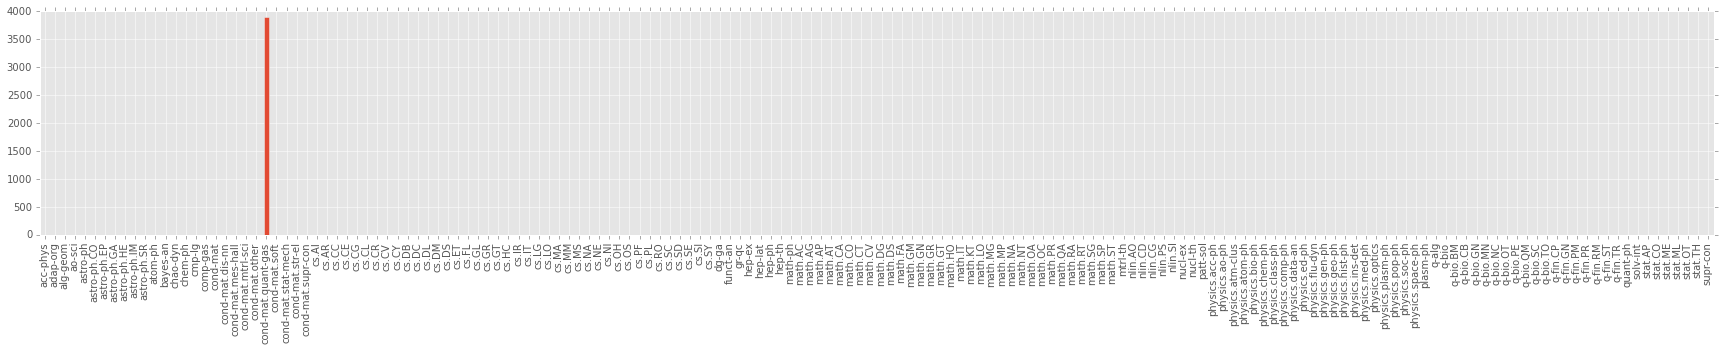

In [32]:
epsilon_categories.loc[589400].plot(kind='bar', figsize=(30, 4))

this is better than the earlier fit - it picks out strongly correlated electronic systems as a category of interest.

look at sachdev / ads cft

In [33]:
id2item = id2arxiv_info

In [34]:
id2item[id2item.arxiv_id == '1002.2947']

,arxiv_id,categories,title,date
32111,1002.2947,hep-th cond-mat.str-el,Condensed matter and AdS/CFT,2010-02-16


In [35]:
np.where(theta[32111]>0)

(array([25, 73]),)

In [36]:
topic2category[73]

'hep-th'

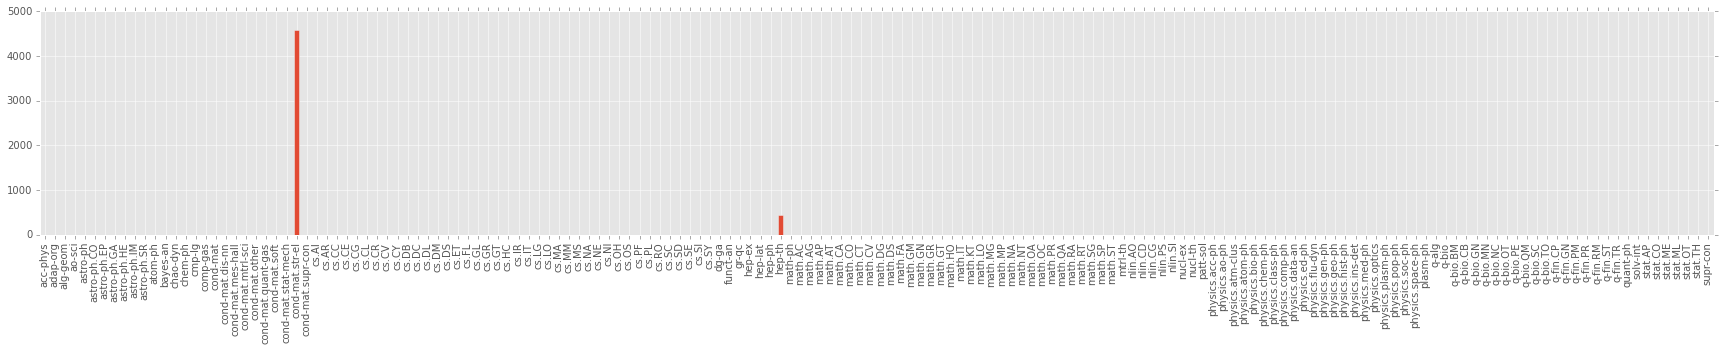

In [37]:
epsilon_categories.loc[32111].plot(kind='bar', figsize=(30, 4))

it captures some extraneous interest, but mostly epsilon is large in the categories corresponding to theta

look at altland & zirnbauer

In [38]:
id2item[id2item.arxiv_id == 'cond-mat/9602137']

,arxiv_id,categories,title,date
247209,cond-mat/9602137,cond-mat,Novel Symmetry Classes in Mesoscopic Normal-Su...,1996-02-27


In [63]:
def plot_eps(doc_id):
    
    display(id2item.iloc[doc_id])
    
    topic = np.where(theta[doc_id]>0)[0][0]

    #print topic2category[topic]

    epsilon_categories.loc[doc_id].plot(kind='bar', figsize=(30, 4), logy=True)

* nb: epsilon can't be strictly zero because the likelihood could be zero, but there is a positive prior contribution too.

arxiv_id                                       cond-mat/9602137
categories                                             cond-mat
title         Novel Symmetry Classes in Mesoscopic Normal-Su...
date                                                 1996-02-27
Name: 247209, dtype: object

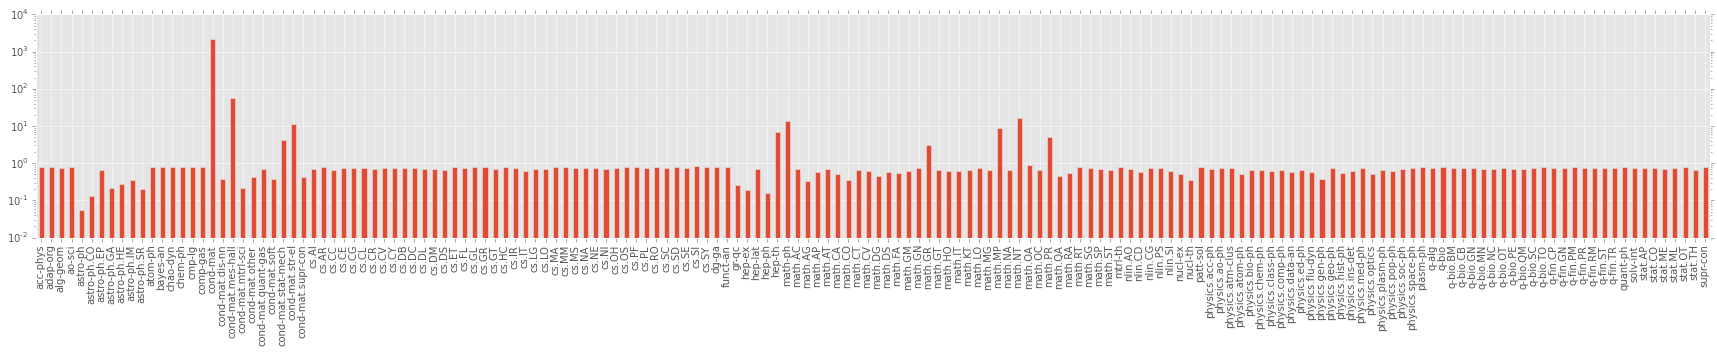

In [64]:
plot_eps(247209)

# look at most popular papers

try to look at most 'popular' papers in condensed matter (epsilon should correspond to clicks?)

In [65]:
def get_top_articles_eps(category, n=10):
    top = epsilon_categories.sort(columns=category, ascending=False)[category]

    top = top[0:n]

    for ID, eps in zip(top.index, top):
        print '{:0.2f}\t {}'.format(eps, id2title[ID])

In [66]:
get_top_articles_eps('cond-mat', n=20)

5783.10	 Entanglement in quantum critical phenomena
5609.93	 Fermi liquids and non--Fermi liquids
5003.20	 Fermi Systems with Strong Forward Scattering
4986.28	 Non Fermi liquid renormalization of the conductivity of fermions coupled to gauge fields
4832.78	 Introduction to the Physics of the Quantum Hall Regime
4667.40	 On the low energy properies of fermions with singular interactions
4586.98	 Tunneling in a bosonized Fermi liquid
4464.41	 Boulevard of Broken Symmetries
4422.48	 Towards exact bosonization of the Calogero-Sutherland model
4348.27	 Theory of Fermion Liquids
4345.38	 Proximity Effect in Presence of Quantum Fluctuations
4296.88	 Spin Stiffness of Mesoscopic Quantum Antiferromagnets
4265.48	 Coupled Luttinger Liquids
4214.50	 The Magnus force in superfluids and superconductors
4193.30	 Bogoliubov's Theory: A Paradigm of Quantum Phase Transitions
4182.81	 Josephson Current and Proximity Effect in Luttinger Liquids
4176.04	 On the Superconductivity of 2D System with Arbitra

In [67]:
get_top_articles_eps('stat.ML', n=20)

16249.11	 Noisy matrix decomposition via convex relaxation: Optimal rates in high dimensions
14344.57	 Robust computation of linear models, or How to find a needle in a haystack
14214.93	 High-dimensional regression with noisy and missing data: Provable guarantees with nonconvexity
13199.10	 Fast global convergence of gradient methods for high-dimensional statistical recovery
11323.89	 Non-negative least squares for high-dimensional linear models: consistency and sparse recovery without regularization
11302.13	 Information-theoretic lower bounds on the oracle complexity of stochastic convex optimization
11094.57	 Stochastic Belief Propagation: A Low-Complexity Alternative to the Sum-Product Algorithm
10806.55	 Randomized Smoothing for Stochastic Optimization
10488.54	 Spectral clustering and the high-dimensional stochastic blockmodel
10300.81	 Concentration-Based Guarantees for Low-Rank Matrix Reconstruction
10267.59	 The asymptotics of ranking algorithms
10240.40	 Multi-stage Convex R

look at norm of epsilon to see if it correlates to popularity

In [68]:
epsilon_norm = np.sqrt(np.square(epsilon_categories).sum(axis=1))

In [50]:
epsilon_norm.sort(ascending=False)

In [51]:
display(id2arxiv_info.iloc[2272].categories)

'hep-ex hep-ph'

In [176]:
for ID, eps in zip(epsilon_norm[0:50].index, epsilon_norm[0:50]):
    print '{:0.2f} {}\t {}'.format(eps, id2arxiv_info.iloc[ID].categories, id2title[ID])

9731.78 quant-ph	 Quantum entanglement between the electron clouds of nucleic acids in DNA
668.14 math.RT	 Geometric representations of GL(n,R), cellular Hecke algebras and the embedding problem
1639.70 hep-ph	 The Galactic Center Region Gamma Ray Excess from A Supersymmetric Leptophilic Higgs Model
2211.32 hep-ph	 Strongly Interacting Gauge Mediation at the LHC
79.56 cond-mat.stat-mech physics.bio-ph physics.chem-ph physics.comp-ph	 A nonequilibrium equality for free energy differences
823.54 nucl-th	 Low-momentum interactions in three- and four-nucleon scattering
2129.62 hep-ph	 Complete electroweak O(alpha) corrections to charged-current e+e- --> 4fermion processes
130.03 hep-th	 General Matter Coupled N=4 Gauged Supergravity in Five Dimensions
185.22 astro-ph	 Toward Understanding the origin of the Fundamental Plane for Early-Type Galaxies
12.48 cond-mat.str-el cond-mat.mtrl-sci	 Large magnetoresistance anomalies in Dy7Rh3
381.27 cond-mat.supr-con cond-mat.mes-hall quant-ph	 Two-ph

^ the top epsilons are imbalanced (or maybe not? this is what we'd expect in pf to explain the data. it means we're not capturing diversity in the way we want)

the proof of innocence is one of the most popular articles on the arxiv in terms of clicks (major press coverage, etc)

In [55]:
id2item[id2item.arxiv_id == '1204.0162']

,arxiv_id,categories,title,date
13057,1204.0162,physics.pop-ph physics.data-an,The Proof of Innocence,2012-04-01


arxiv_id                           1204.0162
categories    physics.pop-ph physics.data-an
title                 The Proof of Innocence
date                              2012-04-01
Name: 13057, dtype: object

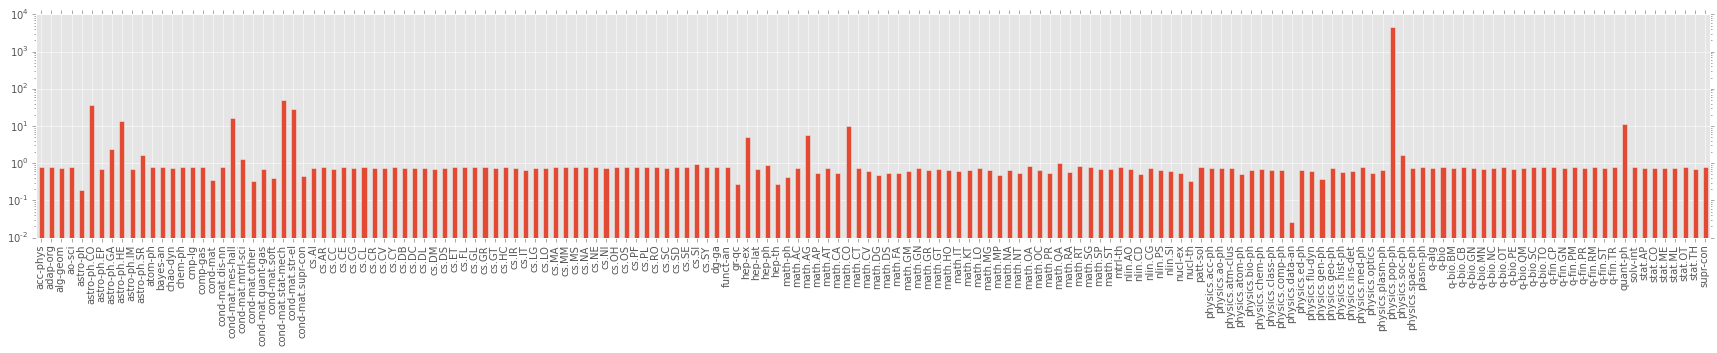

In [69]:
plot_eps(13057)

look at some highly-cited papers (via https://www.quora.com/What-are-some-of-the-most-cited-papers-from-arXiv)

one of the most cited papers in physics: 9711200

In [70]:
id2item[id2item.arxiv_id == 'hep-th/9711200']

,arxiv_id,categories,title,date
8176,hep-th/9711200,hep-th,The Large N Limit of Superconformal Field Theo...,1997-11-27


arxiv_id                                         hep-th/9711200
categories                                               hep-th
title         The Large N Limit of Superconformal Field Theo...
date                                                 1997-11-27
Name: 8176, dtype: object

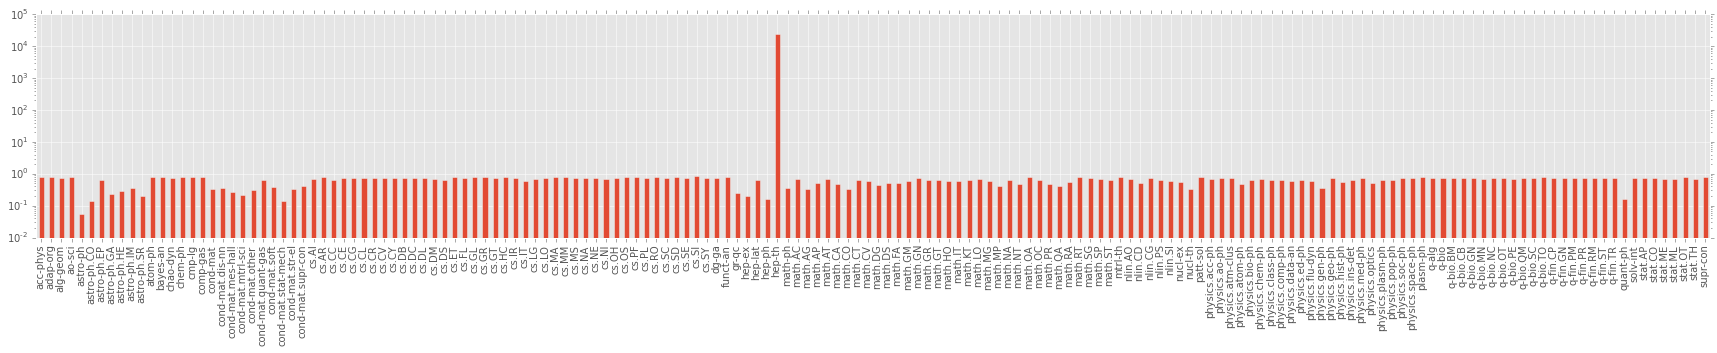

In [71]:
plot_eps(8176)

this is OK, but doesn't really capture inderdisciplinary interest.

In [72]:
lst = ['astro-ph/9812133', 'astro-ph/9805201', 'astro-ph/0302209']

In [73]:
idlist = []
for idx in range(0,len(lst)):
    idlist.append(id2item[id2item.arxiv_id == lst[idx]].index[0])

In [74]:
idlist

[5065, 15852, 104]

arxiv_id                                       astro-ph/9812133
categories                               astro-ph hep-ex hep-ph
title         Measurements of Omega and Lambda from 42 High-...
date                                                 1998-12-07
Name: 5065, dtype: object

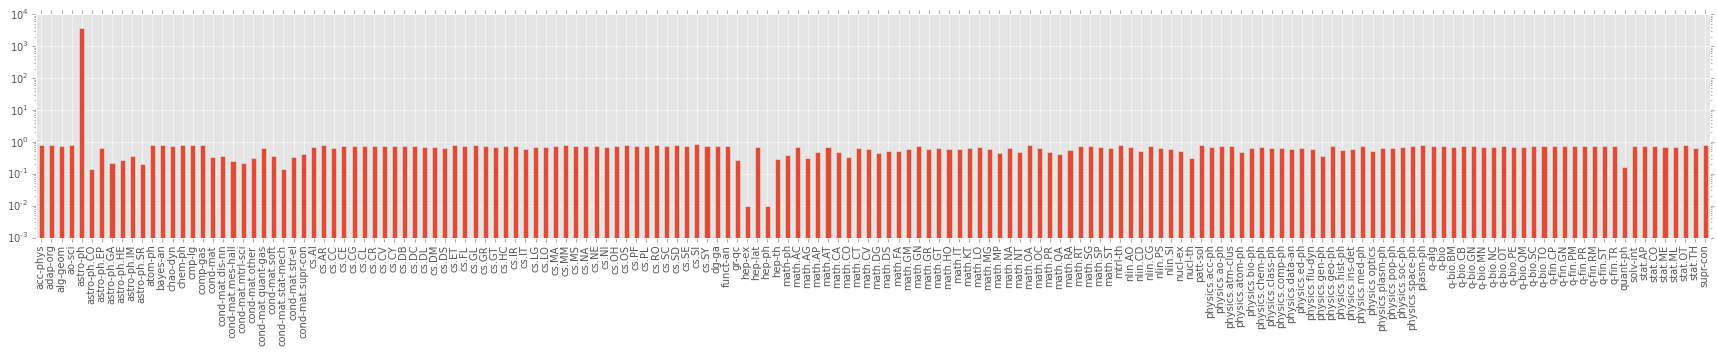

arxiv_id                                       astro-ph/9805201
categories                                             astro-ph
title         Observational Evidence from Supernovae for an ...
date                                                 1998-05-14
Name: 15852, dtype: object

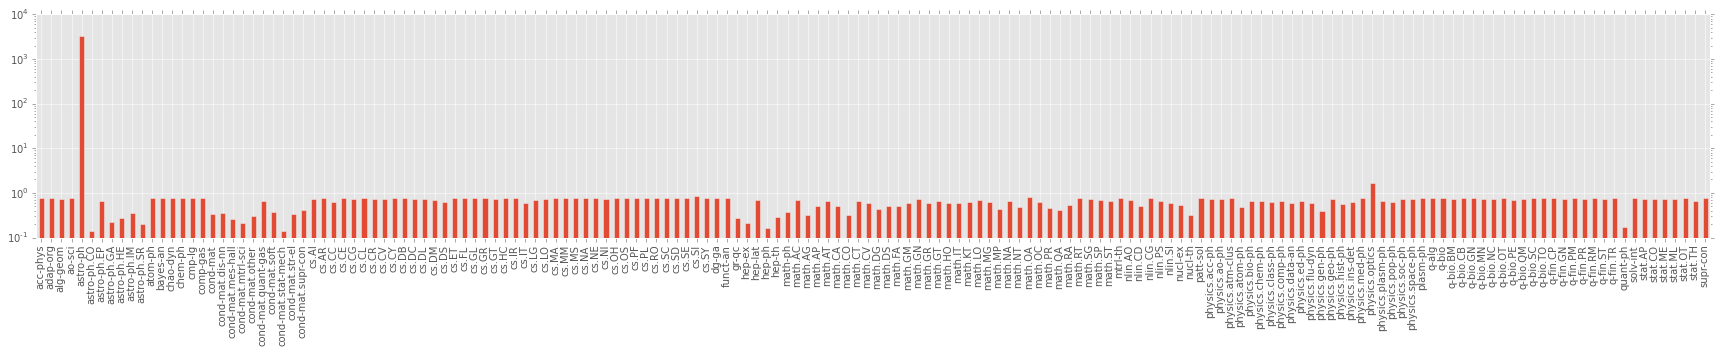

arxiv_id                                       astro-ph/0302209
categories                                             astro-ph
title         First Year Wilkinson Microwave Anisotropy Prob...
date                                                 2003-02-11
Name: 104, dtype: object

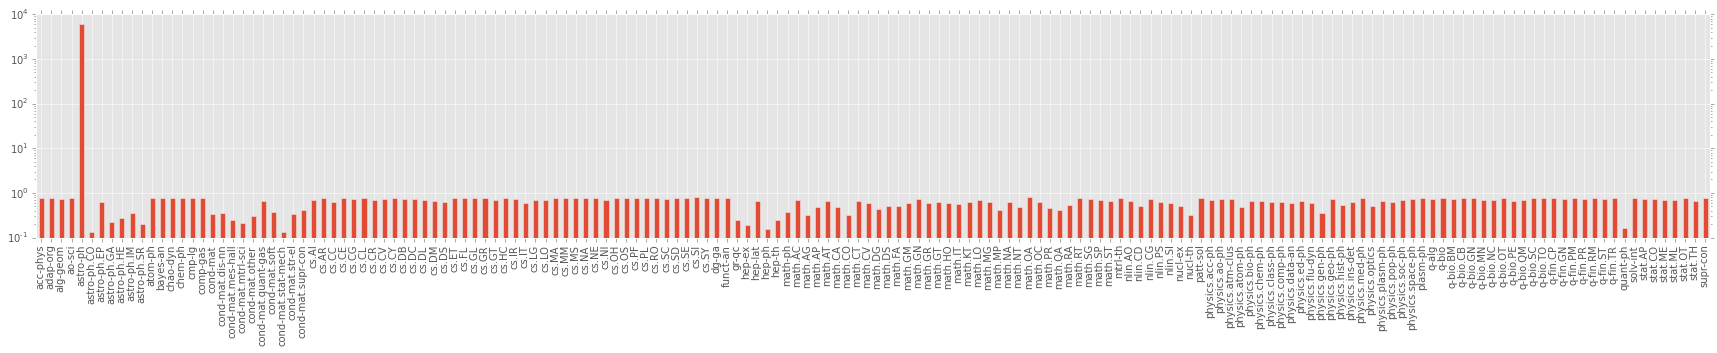

In [75]:
for idx in idlist:
    plot_eps(idx)
    plt.show()
    plt.close()

^ this is good: captures interest in the appropriate categories!

# look at histogram for papers in all categories

In [76]:
theta_categories = pd.DataFrame(data=theta, columns=category_list)

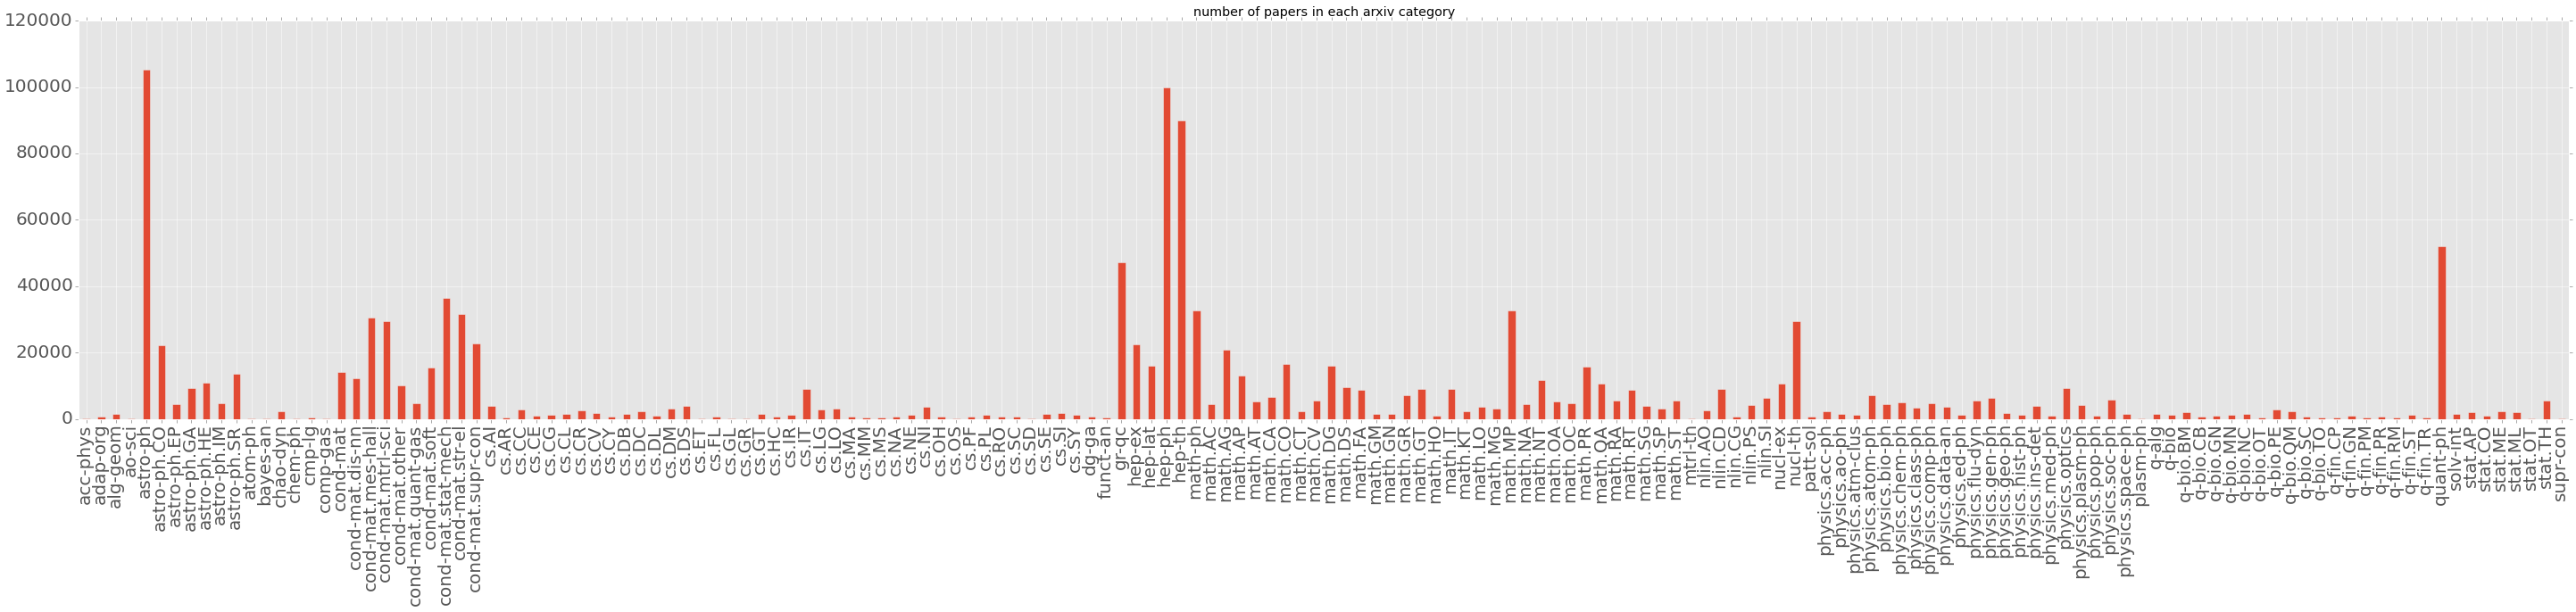

In [95]:
theta_categories.sum().plot(kind='bar',figsize=(50, 8), title='number of papers in each arxiv category', fontsize=20)

In [96]:
betweenFieldArticles('stat.ML', 'quant-ph', n=20)

522.232  Adaptive experimental design for one-qubit state estimation with finite data based on a statistical update criterion
327.458  Quantum learning: optimal classification of qubit states
4.594  On Maximum a Posteriori Estimation of Hidden Markov Processes
3.022  In All Likelihood, Deep Belief Is Not Enough
2.884  Dynamic quantum clustering: a method for visual exploration of structures in data
2.281  Relations among conditional probabilities
2.169  Self-Avoiding Random Dynamics on Integer Complex Systems
1.857  Inferring deterministic causal relations
1.784  Exact Synchronization for Finite-State Sources
1.760  The Computational Structure of Spike Trains
1.550  Large Scale Variational Inference and Experimental Design for Sparse Generalized Linear Models
1.502  Causal inference using the algorithmic Markov condition
1.476  Ultrametric Wavelet Regression of Multivariate Time Series: Application to Colombian Conflict Analysis
1.433  Bayesian Online Changepoint Detection
1.432  Geome

# look at statistics of epsilon correction

which categories have the most 'surprise'? i.e., the highest average theta?

In [78]:
epsilon_describe = epsilon_categories.describe()

In [79]:
epsilon_describe

,acc-phys,adap-org,alg-geom,ao-sci,astro-ph,astro-ph.CO,astro-ph.EP,astro-ph.GA,astro-ph.HE,astro-ph.IM,...,q-fin.TR,quant-ph,solv-int,stat.AP,stat.CO,stat.ME,stat.ML,stat.OT,stat.TH,supr-con
count,806139.000000,806139.000000,806139.000000,806139.000000,806139.000000,806139.000000,806139.000000,806139.000000,806139.000000,806139.000000,...,806139.000000,806139.000000,806139.000000,806139.000000,806139.000000,806139.000000,806139.000000,806139.000000,806139.000000,806139.000000
mean,0.781903,0.779410,0.823951,0.781991,6.850873,14.916327,11.229156,4.938056,12.495117,1.212138,...,0.851382,18.177794,1.603192,0.898277,1.270732,1.280566,2.690397,0.779637,2.118077,0.781033
std,0.015755,0.206693,6.304252,0.015160,87.388567,177.048319,195.240127,77.547094,167.427036,34.182329,...,9.647276,248.940834,32.310426,8.555796,33.137126,25.814374,92.336458,0.017270,31.211022,0.018535
min,0.001162,0.011890,0.018907,0.000423,0.010613,0.004323,0.006058,0.007624,0.006492,0.009387,...,0.007935,0.008948,0.025457,0.025561,0.012644,0.025170,0.017316,0.002768,0.037099,0.004098
25%,0.773966,0.769212,0.739464,0.774021,0.054030,0.133634,0.638634,0.220405,0.271031,0.348307,...,0.755512,0.160557,0.756814,0.717921,0.740090,0.703345,0.709057,0.771479,0.659011,0.773156
50%,0.778586,0.773986,0.744659,0.778623,0.054693,0.134174,0.639434,0.221130,0.272227,0.350553,...,0.760337,0.162557,0.762465,0.722911,0.744575,0.707976,0.712462,0.776069,0.663265,0.777762
75%,0.786392,0.781747,0.753326,0.786408,0.057749,0.138782,0.641749,0.224661,0.278178,0.357490,...,0.768457,0.167442,0.770992,0.731344,0.752118,0.715959,0.718498,0.783795,0.670760,0.785543
max,1.068496,39.803890,1458.696167,1.356909,10062.542969,15648.286133,12241.082031,9551.888672,8653.417969,9134.835938,...,3867.985840,20840.898438,1878.288818,1194.337036,6204.539551,4752.993652,16249.106445,1.262261,3096.413818,1.140968


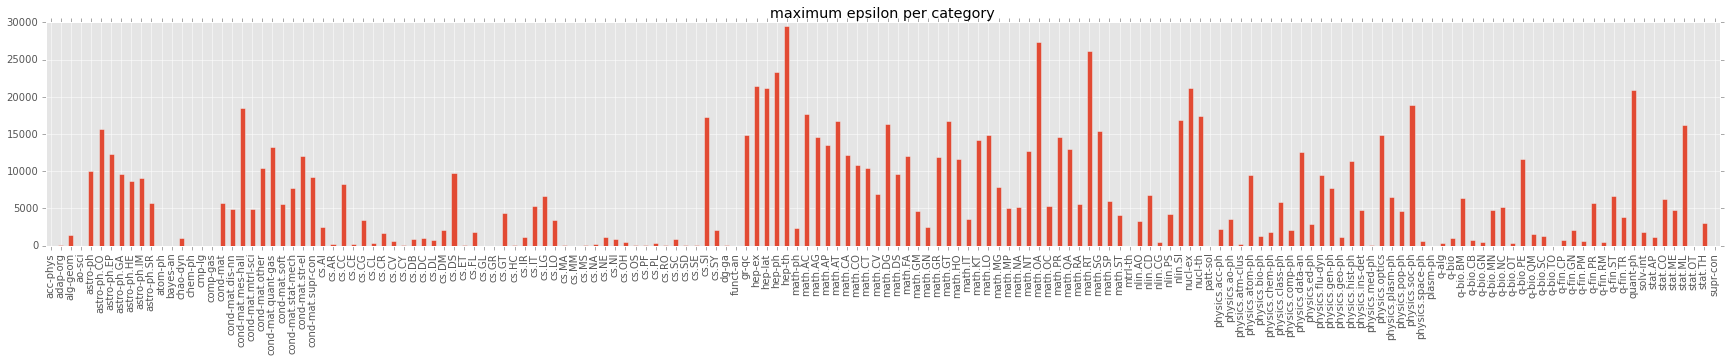

In [80]:
epsilon_describe.iloc[7,:].plot(kind='bar', figsize=(30, 4), title='maximum epsilon per category')

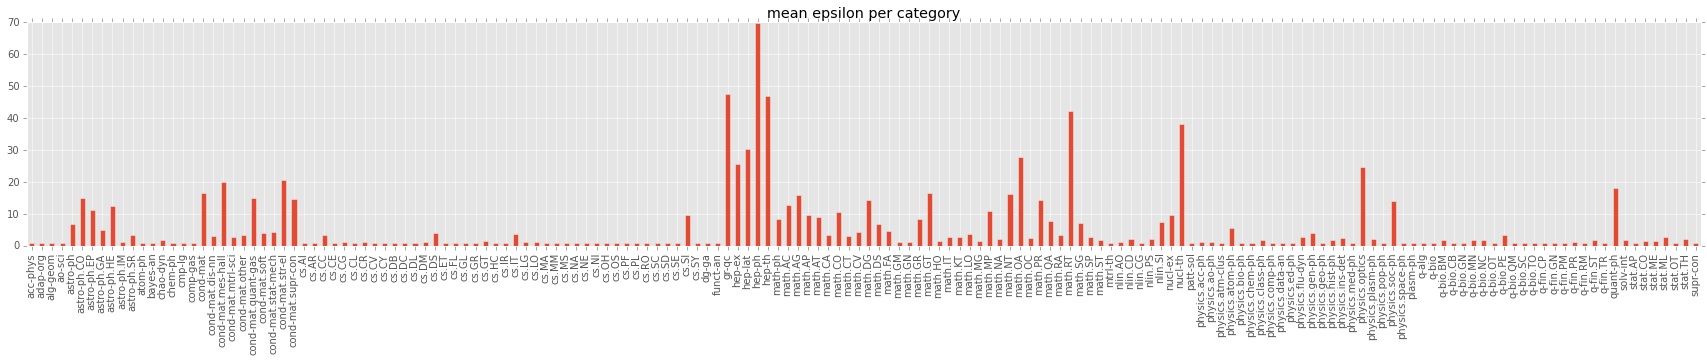

In [81]:
epsilon_describe.iloc[1,:].plot(kind='bar', figsize=(30, 4), title='mean epsilon per category')

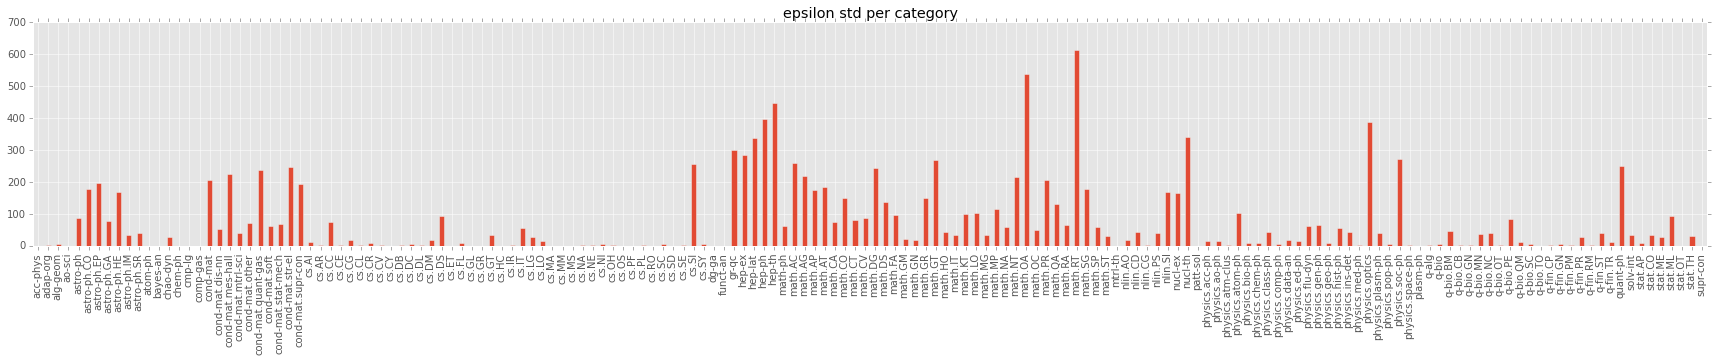

In [82]:
epsilon_describe.iloc[2,:].plot(kind='bar', figsize=(30, 4), title='epsilon std per category')

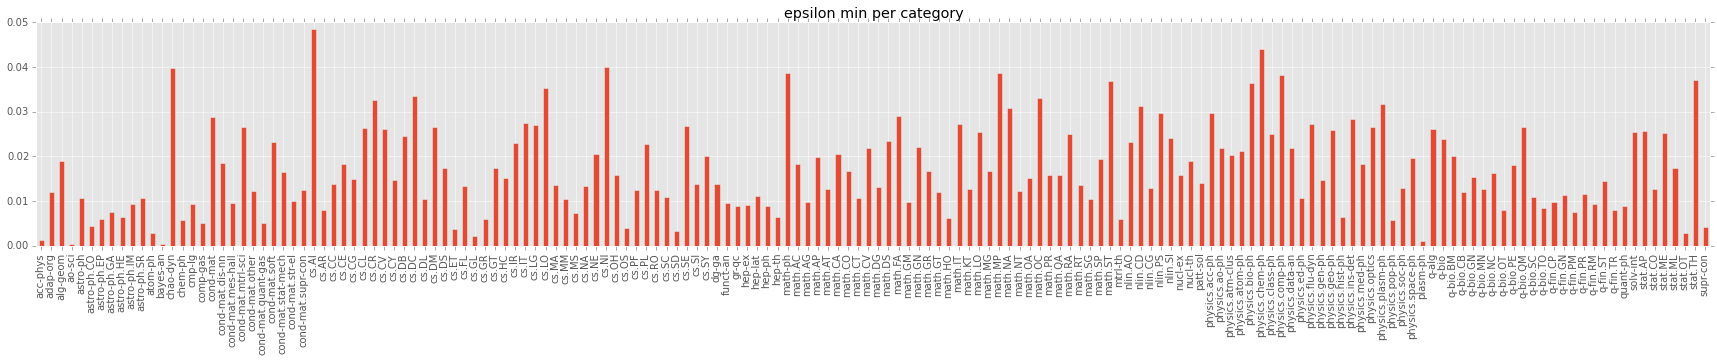

In [83]:
epsilon_describe.iloc[3,:].plot(kind='bar', figsize=(30, 4), title='epsilon min per category')

plot epsilon min and number of papers per category

In [84]:
eps_min = epsilon_describe.iloc[3,:]

In [85]:
num_articles_per_category = theta_categories.sum()

In [86]:
eps_min_and_num = pd.concat([eps_min, num_articles_per_category], axis=1).T

In [87]:
eps_min_and_num.index = ['min', 'num_articles']

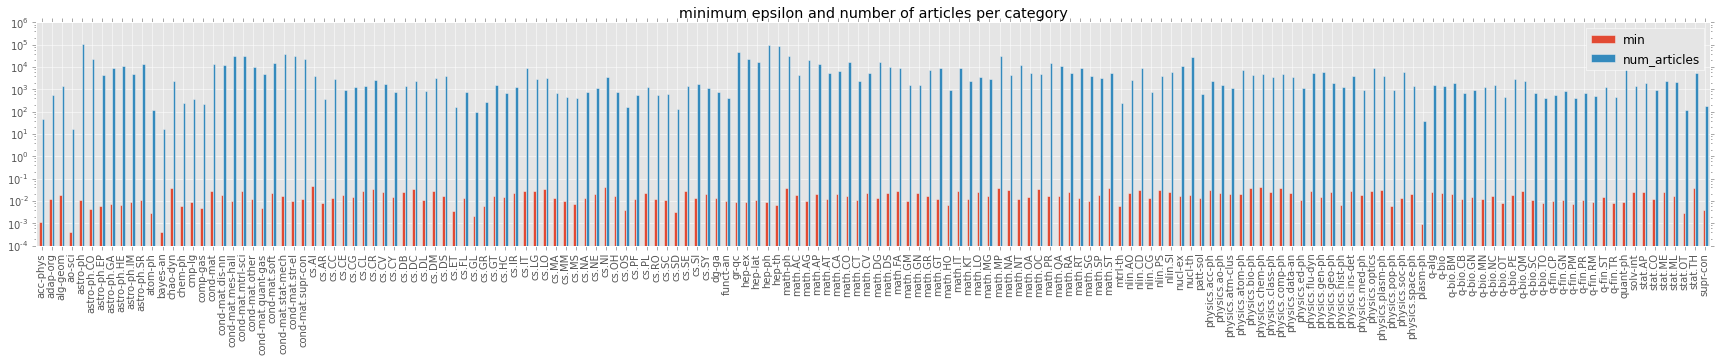

In [88]:
eps_min_and_num.T.plot(kind='bar', figsize=(30, 4), title='minimum epsilon and number of articles per category', logy=True)

# look at individual users' held-out recommendations

In [162]:
def get_doc_list(did_list):
    display(id2arxiv_info.iloc[did_list])
#     for did in did_list:
#         doc_row = id2arxiv_info.iloc[did]
#         print("%s\t%s\t%s\t%s" % (doc_row.arxiv_id, doc_row.categories, doc_row.title[0:20], doc_row.date))

def get_user_history(train_data, user):
    user_col = train_data.getcol(user)
    sorted_idx = np.argsort(-user_col.data)
    raw_did_list = [idx+1 for idx in user_col.nonzero()[0][sorted_idx]]
    get_doc_list(raw_did_list)

def _compare_his_and_rec(user, train_data, Eb=beta, Et=theta, topk=20):
    print("User preferences:")
    user_df = pd.DataFrame(Eb.T[user])
    user_df.index = category_list
    user_df.columns = ['User ' + str(user)]
    user_df.plot(kind='bar', figsize=(50,4), fontsize=20, logy=False)
    plt.show()
    plt.close()
    X_pred = Et.dot(Eb[:, user])
    idx = np.argsort(-X_pred)
    print("User history:")
    get_user_history(train_data, user)
    print("\nRecommendations:")
    get_doc_list([i for i in idx[:topk]])
    
def get_similar_docs(arxiv_id, theta=theta, epsilon=epsilon, n=10):
    idx = id2arxiv_info[id2arxiv_info.arxiv_id == arxiv_id].index[0]
    #Eb = theta + epsilon
    Eb = epsilon
    corr = -Eb.dot(Eb[idx]) / np.sqrt((Eb**2).sum(axis=1)) * np.sqrt((Eb[idx]).sum(keepdims=True))
    max_corr_idx = np.argsort(corr)[:n]
    did_list = [idx for idx in max_corr_idx]

    get_doc_list(did_list)
    print corr[max_corr_idx]

In [145]:
train_data, rows, cols = rec_eval.load_data(in_dir + 'train.tsv', (theta.shape[0], beta.shape[1]), True)

User preferences:


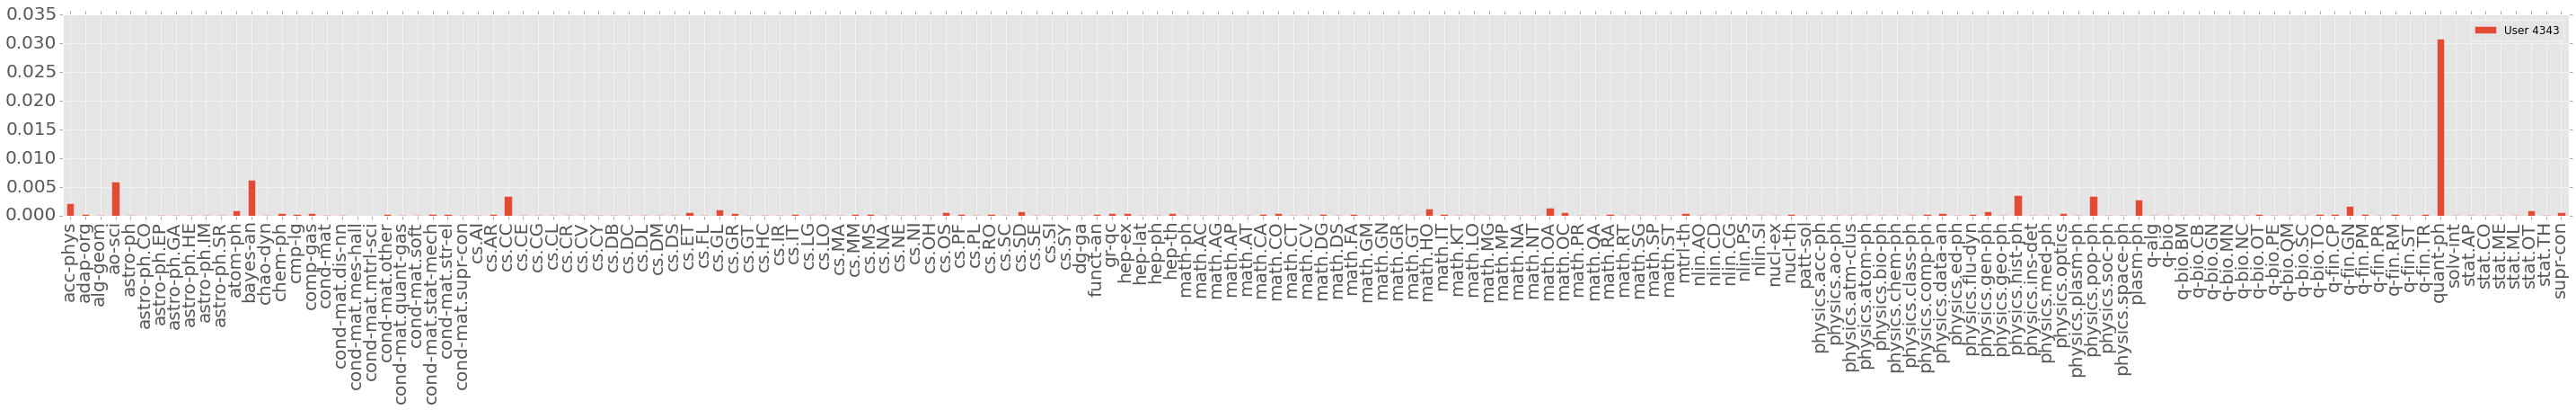

User history:


,arxiv_id,categories,title,date
54,nucl-th/0207056,nucl-th hep-ph,Deep inelastic scattering from light nuclei,2002-07-17
280981,hep-lat/0309153,hep-lat,Deconfinement transition in 2+1-dimensional SU...,2003-09-23
280055,1007.3606,math.GT math.SG,Eliashberg's proof of Cerf's theorem,2010-07-21
279599,1010.2918,cond-mat.mes-hall,Charge transfer statistics of a molecular quan...,2010-10-14
277749,0801.2547,astro-ph,The evolution of the photometric properties of...,2008-01-16
277658,1104.1737,cond-mat.stat-mech,Inverse transition in the two dimensional dipo...,2011-04-09
277551,0909.0767,math.DG,Samuelson's Webs,2009-09-03
276307,cond-mat/9307010,cond-mat,Feedback Effects in Superconductors,1993-07-07
276009,hep-th/9905130,hep-th,Spinor Exchange in AdS_{d+1},1999-05-18
275907,astro-ph/0409004,astro-ph,A Substantial Amount of Hidden Magnetic Energy...,2004-08-31



Recommendations:


,arxiv_id,categories,title,date
595074,quant-ph/9806074,quant-ph gr-qc hep-th math-ph math.MP physics....,On an attempt to resolve the EPR-Bell paradox ...,1998-06-23
78609,physics/0408033,physics.pop-ph gr-qc hep-th physics.hist-ph ph...,"'Information, please... ?'",2004-08-06
473795,quant-ph/9904050,quant-ph cs.CC cs.CY physics.comp-ph physics.p...,"A Computer Scientist's View of Life, the Unive...",1999-04-13
572567,physics/9807012,physics.hist-ph physics.ed-ph physics.pop-ph p...,Louis de Broglie und die Quantenmechanik,1998-07-03
435474,1211.3498,physics.hist-ph physics.pop-ph quant-ph,The Quantum Zeno Effect -- Watched Pots in the...,2012-11-15
343828,1006.4902,quant-ph physics.hist-ph physics.pop-ph,The Hardy Experiment in the Transactional Inte...,2010-06-24
427003,0706.2596,physics.pop-ph physics.hist-ph quant-ph,Is the Interpretation of Delayed-Choice Experi...,2007-06-18
126803,1002.2675,quant-ph physics.hist-ph physics.pop-ph,Better than 'flashes': Transactions,2010-02-12
341922,physics/0005051,physics.hist-ph gr-qc hep-th physics.gen-ph qu...,Fiber Bundle Gauge Theories and 'Field's Dilemma',2000-05-19
44047,hep-ph/0505177,hep-ph cond-mat.other gr-qc hep-lat hep-th mat...,Adventures in Theoretical Physics: Selected Pa...,2005-05-19


In [165]:
_compare_his_and_rec(4343, train_data)

User preferences:


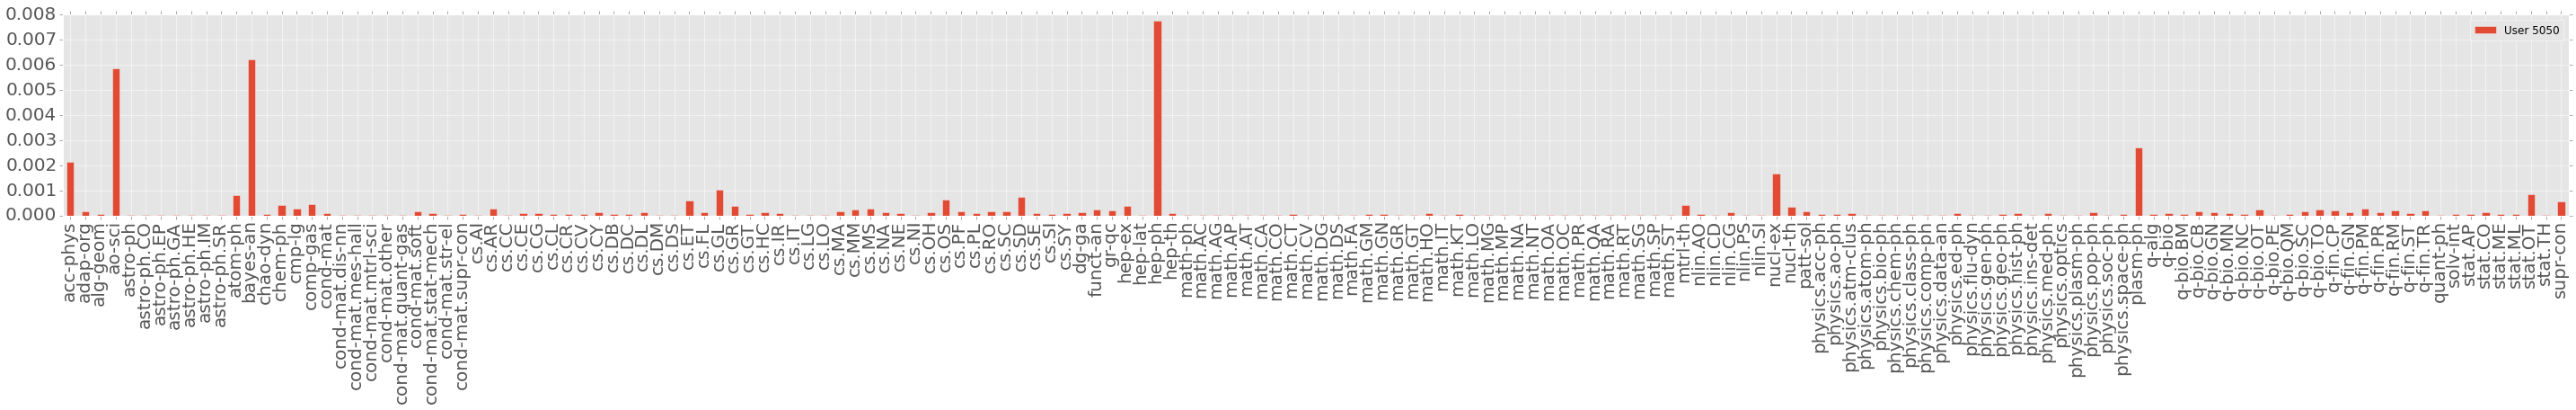

User history:


,arxiv_id,categories,title,date
273,0807.4935,quant-ph,Quantum Communication With Zero-Capacity Channels,2008-07-30
353240,0710.4102,math.AP,Decay of the Maxwell field on the Schwarzschil...,2007-10-22
354258,0706.1169,cs.IT cond-mat.stat-mech math.IT,Vector Precoding for Wireless MIMO Systems: A ...,2007-06-08
355876,0806.4054,math.GR math.AT,Mackey functors and bisets,2008-06-25
356504,physics/0507053,physics.flu-dyn,Heat transport in turbulent Rayleigh-Benard co...,2005-07-06
356658,1110.3859,math.RT hep-th math.NT,"On Rademacher Sums, the Largest Mathieu Group,...",2011-10-17
360195,hep-ph/0702048,hep-ph,Solving problems of 4D minimal SO(10) model in...,2007-02-04
360654,quant-ph/0304102,quant-ph,Capacities of Quantum Channels and How to Find...,2003-04-14
361257,astro-ph/0403606,astro-ph,Two New Low Galactic D/H Measurements from FUSE,2004-03-25
361944,physics/0610010,physics.plasm-ph astro-ph cond-mat.mtrl-sci ph...,Electromagnetic field of fractal distribution ...,2006-10-02



Recommendations:


,arxiv_id,categories,title,date
70509,physics/9611016,physics.data-an astro-ph bayes-an hep-ph nucl-ex,A Theory of Measurement Uncertainty Based on C...,1996-11-21
453044,hep-ph/9512295,hep-ph astro-ph bayes-an cond-mat physics.data-an,Probability and Measurement Uncertainty in Phy...,1995-12-11
789242,hep-ph/9605236,hep-ph acc-phys astro-ph plasm-ph,High energy proton acceleration in dissolving ...,1996-05-06
613413,hep-ph/9604368,hep-ph acc-phys atom-ph quant-ph,Sonoluminescence and the Heimlich Effect,1996-04-19
68539,hep-ph/0502196,hep-ph astro-ph gr-qc hep-ex nucl-ex nucl-th,Solar mass-varying neutrino oscillations,2005-02-21
235012,astro-ph/0010398,astro-ph gr-qc hep-ex hep-ph nucl-ex nucl-th,Black Hole Formation in Core-Collapse Supernov...,2000-10-19
402766,hep-ph/0006015,hep-ph astro-ph gr-qc hep-ex nucl-ex nucl-th,Technique for Direct eV-Scale Measurements of ...,2000-06-01
551938,0906.3709,nucl-th gr-qc hep-ex hep-ph nucl-ex,Baryon Resonance Analysis from SAID,2009-06-19
224516,hep-ph/0010019,hep-ph cond-mat hep-ex hep-th nucl-ex nucl-th ...,q-Boson approach to multiparticle correlations,2000-10-03
58977,1112.2770,astro-ph.IM hep-ex hep-ph nucl-ex nucl-th phys...,The Impact of Recent Advances in Laboratory As...,2011-12-09


In [166]:
_compare_his_and_rec(5050, train_data)

# look at most similar documents by epsilon or theta

In [131]:
get_similar_docs('1206.7051', n=50)

,arxiv_id,categories,title,date
3806,1206.7051,stat.ML cs.AI stat.CO stat.ME,Stochastic Variational Inference,2012-06-29
173671,0908.0050,stat.ML cs.LG math.OC,Online Learning for Matrix Factorization and S...,2009-08-01
78012,1109.1990,cs.LG stat.ML,Trace Lasso: a trace norm regularization for c...,2011-09-09
364853,1009.2722,stat.ML cs.IT math.IT,Learning Latent Tree Graphical Models,2010-09-14
444498,1206.0333,cs.LG stat.ML,Sparse Trace Norm Regularization,2012-06-01
587205,1112.2679,stat.ML cs.AI,Truncated Power Method for Sparse Eigenvalue P...,2011-12-12
230176,1005.4717,stat.ML cs.LG math.OC stat.AP stat.CO,Smoothing proximal gradient method for general...,2010-05-25
109245,1111.5479,stat.ML cs.LG,The Graphical Lasso: New Insights and Alternat...,2011-11-23
244993,1006.3316,stat.ML,Stability Approach to Regularization Selection...,2010-06-16
465766,1212.0467,stat.ML cs.LG math.OC,Low-rank Matrix Completion using Alternating M...,2012-12-03


[-289353.5625  -289353.5625  -289353.5625  -289353.53125 -289353.53125
 -289353.53125 -289353.53125 -289353.53125 -289353.53125 -289353.53125
 -289353.53125 -289353.53125 -289353.53125 -289353.53125 -289353.53125
 -289353.53125 -289353.53125 -289353.53125 -289353.53125 -289353.53125
 -289353.53125 -289353.5     -289353.5     -289353.5     -289353.5
 -289353.5     -289353.5     -289353.5     -289353.5     -289353.5
 -289353.5     -289353.5     -289353.5     -289353.5     -289353.46875
 -289353.46875 -289353.46875 -289353.46875 -289353.46875 -289353.46875
 -289353.46875 -289353.46875 -289353.46875 -289353.46875 -289353.4375
 -289353.4375  -289353.4375  -289353.4375  -289353.4375  -289353.4375 ]
